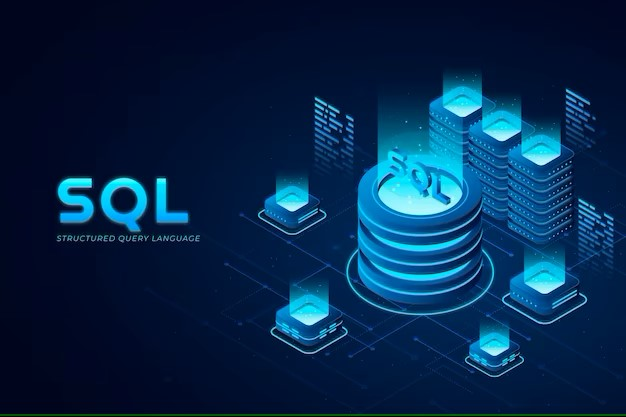

##  Answering Business Questions for Chinook Using SQL 

### Introduction:

The Chinook record store has just signed a deal with a new record label, and I've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


Artist Name| Genre |
-----------|------- |
Regal |	Hip-Hop
Red Tone  |	Punk
Meteor and the Girls  |	Pop
Slim Jim Bites |	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

#### Loading in the database and exploring the database:

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### The schema of the database: 
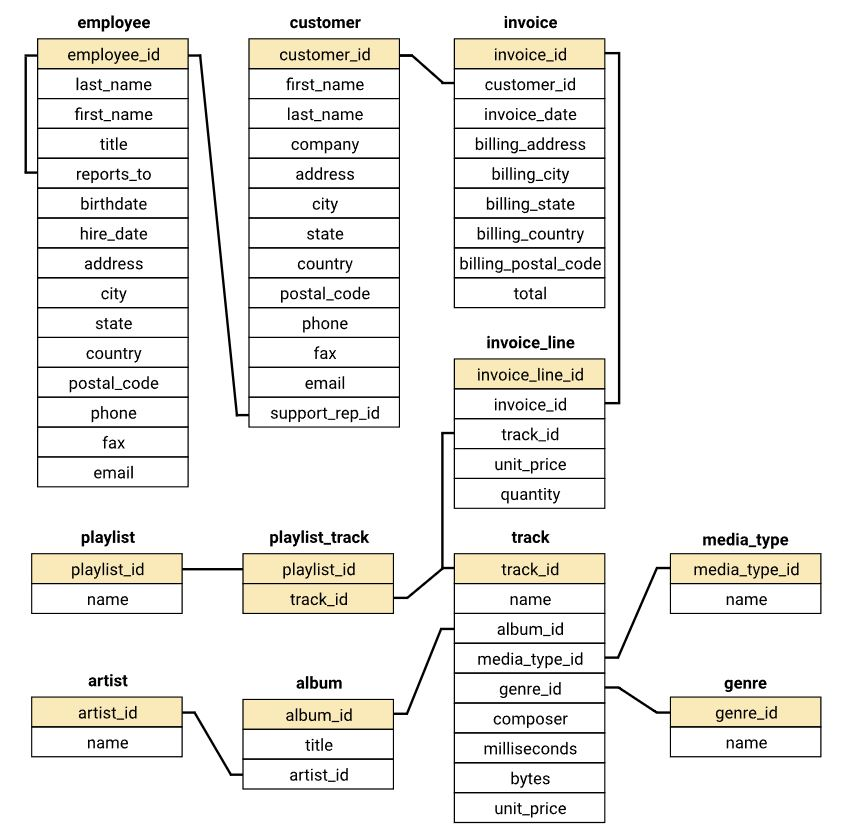

### Selecting Albums to Purchase:

In [3]:
%%sql

WITH 
     usa_customers AS 
     (SELECT * 
       FROM customer AS c 
      INNER JOIN invoice AS i 
            ON i.customer_id = c.customer_id
      INNER JOIN invoice_line AS il
            ON il.invoice_id = i.invoice_id
      WHERE i.billing_country = 'USA')
    
SELECT gn.name AS Genre, 
       billing_country, 
       COUNT(total) AS track_sold,
       ROUND(CAST (COUNT(usa_customers.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) 
          FROM usa_customers) *100 ,1) AS percentage
  FROM usa_customers     
 INNER JOIN track AS t 
       ON t.track_id = usa_customers.track_id
 INNER JOIN genre AS gn
       ON gn.genre_id = t.genre_id 
 GROUP BY Genre
 ORDER BY track_sold DESC;

Done.


Genre,billing_country,track_sold,percentage
Rock,USA,561,53.4
Alternative & Punk,USA,130,12.4
Metal,USA,124,11.8
R&B/Soul,USA,53,5.0
Blues,USA,36,3.4
Alternative,USA,35,3.3
Latin,USA,22,2.1
Pop,USA,22,2.1
Hip Hop/Rap,USA,20,1.9
Jazz,USA,14,1.3


#### Top 3 Albums to purchase would be:

1) Red Tone's in the Punk genre as Punk is ranked number 2.  

2) Slim Jim Bites in the Blues genre. Blues is ranked number 5.

3) Meteor and the Girls in the Pop genre. Pop is ranked number 8. 

Regal is in the Hip-Hop Genre. Hip Hop is ranked number 9. Which is the lowest of the 4. 

###  Analyzing Employee Sales Performance:

Chinook has asked for the performance of each sales employee to be analyzed. I will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [4]:
%%sql

WITH 
    total_sale AS 
        (SELECT SUM(i.total)
FROM invoice AS i 
  INNER JOIN customer AS cs
            ON cs.customer_id = i.customer_id)

SELECT em.first_name|| " " || em.last_name AS employee_name,
       em.title,
       em.hire_date as hire_date,
       ROUND(SUM(i.total)) AS total_sales,
       ROUND (CAST(SUM(i.total) AS FLOAT) / 
            (SELECT * FROM total_sale)* 100, 1) AS total_pct,  
       COUNT(i.customer_id) AS total_customers
       
  FROM employee AS em
  INNER JOIN customer AS cs 
            ON cs.support_rep_id = em.employee_id
  INNER JOIN invoice AS i 
            ON i.customer_id = cs.customer_id 
  WHERE em.title = 'Sales Support Agent' 
  GROUP BY employee_name


Done.


employee_name,title,hire_date,total_sales,total_pct,total_customers
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1732.0,36.8,212
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.0,33.6,214
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1394.0,29.6,188


#### Summary of Employee Sales:

As we can see Jane Peacock is the top seller with 1,732 total sales with a 36.8% total sales percent. Margaret Park is in second place and Steve Johnson is in last place. 

There is not much data to support the difference between employee performance besides start date. Jane has the most time on the job by 6 months compared to Steve Johnson. 

Many factors can impact performance that we are missing data on. Such as the time the employee works, the hours a week worked, etc. 

### Analyzing Sales by Country:

Chinook has now asked for the sales data for customers in each country. 
Specifically they want to calculate data, for each country, on the:

* Total number of customers
* Total value of sales
* Average value of sales per customer
* Average order value

Because there are a number of countries with only one customer, Chinook wants these to be grouped as "Other". As they are more interested in countries with more than one customer. 

In [5]:
%%sql

WITH 

countries_count AS 
    (SELECT c.country AS country, COUNT(c.customer_id) AS total_customers
       FROM customer AS c
     GROUP BY c.country
     ORDER BY total_customers DESC),

sales_data AS 
     (SELECT c.country AS country, ROUND(SUM(i.total), 2) AS total_sales,
             COUNT(i.invoice_id) AS num_sales
        FROM customer AS c 
        JOIN invoice AS i 
          ON c.customer_id = i.customer_id
       GROUP BY c.country),

other_countries AS
     (SELECT CASE WHEN countries_count.total_customers = 1 THEN 'Others'
                                ELSE countries_count.country END AS country_name, 
                           SUM(countries_count.total_customers) AS total_customers,
                           SUM(sales_data.total_sales) AS total_sales,
                           SUM(sales_data.num_sales) AS number_sales
                      FROM countries_count
                      JOIN sales_data
                        ON countries_count.country = sales_data.country
                     GROUP BY 1)   

SELECT country_name, 
       total_customers, 
       total_sales,
       ROUND(total_sales / number_sales, 2) AS avg_order_value,
       ROUND(total_sales / total_customers, 2) AS avg_sales_per_customer
  FROM (SELECT *, 
          CASE WHEN country_name = 'Others' THEN 1
          ELSE 0 
           END AS sort
          FROM other_countries)
  ORDER BY sort, total_customers DESC;

Done.


country_name,total_customers,total_sales,avg_order_value,avg_sales_per_customer
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
United Kingdom,3,245.52,8.77,81.84
Czech Republic,2,273.24,9.11,136.62
India,2,183.15,8.72,91.58
Portugal,2,185.13,6.38,92.56
Others,15,1094.94,7.45,73.0


The USA has the most customers and total sales. 
The country with the highest average sales per and average order price per customer is the Czech Republic. 

The results are a bit skewed with the Czech Republic since the sample size is only 2 customers.

### Albums vs Individual Tracks

The management of Chinook is currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that Chinook management can use this data to understand the effect this decision might have on overall revenue.

In [32]:
%%sql

WITH 
   il_table AS 
    (SELECT il.invoice_id, t.album_id
       FROM invoice_line AS il 
       LEFT JOIN track as t 
             ON t.track_id =il.track_id
       LEFT JOIN album as al 
             ON al.album_id = t.album_id
       GROUP BY invoice_id), 

except_table AS     
    (SELECT CASE WHEN
    (SELECT track_id
       FROM invoice_line AS il 
      WHERE il_table.invoice_id = il.invoice_id
     EXCEPT 
     SELECT track_id
       FROM track
      WHERE track.album_id = il_table.album_id) IS NULL
      
      AND
     
     (SELECT track_id
        FROM track
       WHERE track.album_id = il_table.album_id
      EXCEPT
      SELECT track_id 
        FROM invoice_line AS il 
       WHERE il_table.invoice_id = il.invoice_id) IS NULL
     
       THEN 'Yes'
       ELSE 'No'
       END AS 'Purchased_Album'
       FROM il_table)
    
SELECT Purchased_Album,
       COUNT(Purchased_Album) AS invoices,
       
        ROUND(CAST(COUNT(Purchased_Album) * 100 AS FLOAT) / 
       (SELECT COUNT(Purchased_Album) 
         FROM except_table),1) AS PCT_of_Invoices 
  
  FROM except_table
 GROUP BY Purchased_Album
 ORDER BY Purchased_Album DESC;

Done.


Purchased_Album,invoices,PCT_of_Invoices
Yes,114,18.6
No,500,81.4


The purchases of albums is about 18.6% of all purchases made. 
Even though 81% of purchases come from individual tracks this would be a 
significant decrease in revenue if they remove album purchases. 

### Conclusion: 

In this project we have succesfully answered 4 questions from Chinook: 

* The top 3 albums to purchase for Chinook Record Store
* Analyzed the performance of employees 
* Analyzed sales by Country. 
* Explored the option of purchasing individual tracks vs Albums. 